 <div style="text-align:center;">
  <span style="color:green; font-size:2em; font-weight:bold;">Modélisation</span><br><br>

# <span style="color:green">Introduction</span><br><br> 

### <span style="color:green">Références et équations de base de la relation d'Okun</span><br><br> 

Dans cette partie, nous allons proposer une modélisation permettant de vérifier empiriquement la loi d'Okun, à partir des bases de données établies dans la partie "Préparation_données.ipynb".

La loi d'Okun, indique que : "chaque fois que le PIB chute d'un certain pourcentage, par rapport au produit potentiel, le taux de chômage augmente d'environ un point de pourcentage. Ainsi, lorsque le PIB réel diminue, le taux de chômage augmente." (Mankiw, 2003)

Pour cette modélisation, on s'inspire des travaux suivants : 

- [1]. Traoré, D. L., Diakite, S., & Mariko, O. (2021). Croissance et chômage au Mali : Vérification empirique de la loi d'Okun. Revue Malienne de Science et de Technologie, Série C : Sciences Humaines et Sociales, 02(25), Page. ISSN 1987-1031. CNRST, Bamako, Mali.

- [2]. Aassif, Z. L'extraction de la tendance cycle. Haut-Commissariat au Plan, Direction de la comptabilité nationale. 

- [3]. Belaidi, N. (2022, 28 mars). Validation croisée en Machine Learning. Consulté le  12 décembre 2023. URL : https://blent.ai/blog/a/validation-croisee-machine-learning.


Le travail [1] nous présente deux équations de base de la relation d'Okun, la version en "différences premières" et la "version gap".

- Version en "différences premières" : 
$$\Delta u = C + \beta\Delta \text{pib} + \epsilon$$

- "Version gap" : 
$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

avec $u$ le taux de chômage, $u^*$ le taux de chômage naturel, $\text{pib}^*$ le PIB potentiel et c, $\beta$ et $\epsilon$  des constantes à déterminer grâce à la modélisation. 

### <span style="color:green">Equation et outils utilisés dans notre modélisation</span><br><br> 

Pour la modélisation, nous allons utiliser la version "gap", qui relie le taux de chômage et le PIB de la manière suivante : 

$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

Pour extraire la tendance à long terme du taux de chômage et du PIB (c'est-à-dire, le taux de chômage naturel et le PIB potentiel), à partir de la base de données, nous allons utiliser le filtre de Hodrick-Prescott. Ce filtre est introduit dans [2], et permet de décomposer une série selon sa tendance à long terme et son cycle (fluctuations autour de la tendance) à plus court terme.

Par ailleurs, pour prendre en compte la dynamique temporelle de nos données, nous allons utiliser le modèle ARDL (Auto Regressive Distributed Lag), introduit dans [2].

### <span style="color:green">Les différentes étapes de notre modélisation</span><br><br> 


Pour effectuer notre modélisation sur les données obtenues suite au traitement, nous allons tout d'abord regrouper les pays présents selon différents critères, grâce à la technique du clustering. 
Nous sélectionnerons un pays de manière aléatoire au sein de chaque groupe afin de vérifier la loi d'Okun (ou alors nous vérifierons la loi d'Okun pour chaque groupe après agrégation).

(Par ailleurs, nous allons utiliser une méthode de validation croisée afin de valider notre modèle. Nous allons tout d'abord établir les paramètres du modèle grâce au jeu d'entrainement reprenant les données de 1994 à 2016 ; puis nous vérifierons la précision du modèle grâce au jeu de test reprenant les données de 2017 à 2023.)


# <span style="color:green"> I- Extraction de la tendance à long terme du taux de chômage et du PIB</span><br><br> 

## <span style="color:green"> Importation des bases de données</span><br><br> 

In [99]:
import declarations as d 

In [100]:
# Base de données obtenue suite au nettoyage
data = d.pd.read_csv('bases/final_data.csv', encoding='latin-1')
data.head(2)

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694


### <span style="color:green"> Base de données pour la modélisation des séries temporelles </span><br><br> 

Pour la modélisation des séries temporelles modélisant la relation entre le PIB et le taux de chômage, nous avons besoin de ces variables pour chaque pays en colonnes et de la date en indice. 

In [11]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_pivot = data.pivot(index=['YEAR'], columns='COUNTRY',
                    values=['Unemployment_rate', 'GDP_rate'])

# Ajuster les noms de colonnes
df_pivot.columns = [f'{col[1]}_{col[0].lower()}' for col in df_pivot.columns]

# Réinitialiser l'index pour avoir les colonnes YEAR et MONTH comme des colonnes régulières
df_pivot.reset_index(inplace=True)

# Afficher le nouveau dataframe
df_pivot.head(2)


,YEAR,AUS_unemployment_rate,AUT_unemployment_rate,BEL_unemployment_rate,BGR_unemployment_rate,CAN_unemployment_rate,CHE_unemployment_rate,CZE_unemployment_rate,DEU_unemployment_rate,ESP_unemployment_rate,...,POL_gdp_rate,PRT_gdp_rate,ROU_gdp_rate,RUS_gdp_rate,SGP_gdp_rate,SVK_gdp_rate,SVN_gdp_rate,SWE_gdp_rate,URY_gdp_rate,USA_gdp_rate
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


In [101]:
df_pivot = df_pivot.rename(columns=lambda x: x.replace('_rate', ''))
df_pivot.head(2)

,YEAR,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


### <span style="color:green"> Base de données pour le clustering </span><br><br> 

Pour le clustering, nous avons besoin d'une base de données avec en indice le nom des pays et en colonnes, les différents critères considérés, moyennés sur la période considérée.

In [102]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_cluster = data.pivot_table(index='COUNTRY', values=['Unemployment_rate', 'GDP_rate','life_expentancy',
       'pop_growth_rate'], aggfunc='mean')

df_cluster.head(2)

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969


## <span style="color:green">Extraction de la tendance à long terme pour le taux de chômage (unemployement)</span><br><br> 

In [103]:
# Extraire toutes les colonnes avec le suffixe "_rate" ainsi que la colonne des dates
columns_unemployment = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_unemployment')] 
df_unemployment = df_pivot[columns_unemployment]
df_unemployment.set_index('YEAR', inplace = True)

df_unemployment.head(2)

,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,EST_unemployment,...,POL_unemployment,PRT_unemployment,ROU_unemployment,RUS_unemployment,SGP_unemployment,SVK_unemployment,SVN_unemployment,SWE_unemployment,URY_unemployment,USA_unemployment
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,7.600000,...,16.450000,7.756329,10.9,6.759498,1.750000,14.620000,14.650000,10.839335,12.100000,6.2
1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,7.466667,...,16.533333,7.916827,10.9,6.574419,1.666667,14.426667,14.966667,10.866990,12.083333,6.5


## <span style="color:green">Extraction de la tendance à long terme pour le PIB (gdp)</span><br><br> 

In [104]:
# Extraire toutes les colonnes avec le suffixe "_gdp" ainsi que la colonne des dates
columns_gdp = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_gdp')] 
df_gdp = df_pivot[columns_gdp]
df_gdp.set_index('YEAR', inplace = True)

df_gdp.head(2)

,AUS_gdp,AUT_gdp,BEL_gdp,BGR_gdp,CAN_gdp,CHE_gdp,CZE_gdp,DEU_gdp,ESP_gdp,EST_gdp,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,0.501645,0.779464,0.796550,0.559233,0.680429,0.907331,0.814153,0.794548,0.774291,0.525902,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1994-02,0.502208,0.783616,0.798246,0.559740,0.680180,0.909250,0.818056,0.796374,0.778426,0.534253,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


# II- Clustering : regroupement des pays selon des critères de développement

Dans cette partie, on va utiliser la méthode du clustering pour regrouper les pays de la base de données selon 4 critères : 
- le PIB,
- le taux de chômage, 
- la durée de vie,
- et le taux de croissance de la population. 
chaque variable moyennée sur la période considérée. 


In [105]:
# on supprime d'abord les lignes ayant des valeurs manquantes
df_cluster.dropna(inplace=True)
df_cluster.head()

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969
BEL,0.913237,7.774560,79.483950,0.498965
BGR,0.799515,10.575434,72.878191,-0.792854
CAN,0.922738,7.485185,80.470733,1.032642


In [106]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


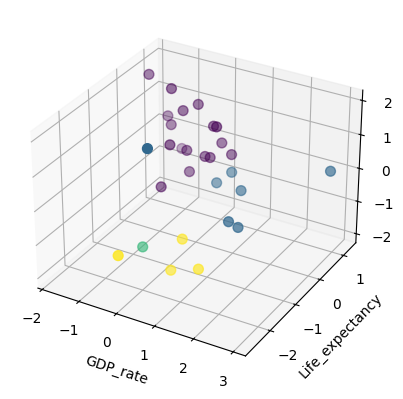

In [107]:
# Standardiser les données (important pour K-means)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Appliquer l'algorithme K-means
num_clusters = 4  # Choisissez le nombre de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualisation en 3D (utilisant les variables GDP_rate, Life_expectance, Pop_growth_rate)
fig = d.plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:, 1], df_scaled[:, 2], df_scaled[:, 3], c=df_cluster['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('GDP_rate')
ax.set_ylabel('Life_expectancy')
ax.set_zlabel('Pop_growth_rate')
d.plt.show()

In [110]:
# Afficher les groupes et les pays
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    print(f'Cluster {cluster_num + 1}: {list(countries_in_cluster)}')

Cluster 1: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CZE', 'DEU', 'FRA', 'GBR', 'IRL', 'JPN', 'LUX', 'NOR', 'NZL', 'SGP', 'SWE', 'USA']
Cluster 2: ['ESP', 'FIN', 'PHL', 'POL', 'PRT', 'SVK', 'SVN']
Cluster 3: ['ROU']
Cluster 4: ['BGR', 'EST', 'LTU', 'RUS']


# III- Vérification de la loi pour un pays tiré aléatoirement dans chaque groupe


## Modélisation de la relation entre PIB et taux de chômage, pour un pays donné, grâce au modèle ARDL 

### Extraction de la tendance à long terme du PIB et du taux de chômage d'un pays.

Dans cette partie, on définit une classe qui permet de tracer la tendance à long terme et les cycles à court terme des deux variables considérées. 

La méthode df_gap() de cette classe permet d'obtenir une série avec les valeurs de la différence entre la valeur réelle et la tendance à long terme des deux variables considérées, pour un pays considéré. 

In [132]:
class CountryData:
    def __init__(self, country_code, unemployment_data, gdp_data):
        """
        Initialize a CountryData instance.

        Parameters:
        - country_code (str): The country code.
        - unemployment_data (pd.Series): Time series data for unemployment rate.
        - gdp_data (pd.Series): Time series data for GDP rate.
        """
        
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']

    def plot_trend_cycle(self):
        """
        Plot the trend and cycle components for unemployment rate and GDP rate after applying the Hodrick-Prescott filter to the time series.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)

        # Plot the trend and cycle of unemployment rate
        d.plt.plot(x, label='Original series')
        d.plt.plot(trend_x, label='Trend')
        d.plt.plot(cycle_x, label='Cycle')
        d.plt.legend()
        d.plt.show()

        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)

        # Plot the trend and cycle of the trend
        d.plt.plot(y, label='Originale series')
        d.plt.plot(trend_y, label='Trend')
        d.plt.plot(cycle_y, label='Cycle')
        d.plt.legend()
        d.plt.show()
        
    def df_gap(self):
        """
        Calculate the gap series for unemployment rate and GDP rate.

        Returns:
        - df_gap (pd.DataFrame): DataFrame containing the gap values.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)
    
        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)
    
        # Calculate the new series by removing the trend
        gap_unemployment = x - trend_x
        gap_gdp = y - trend_y

        # Create a DataFrame with the new series
        df_x = d.pd.DataFrame({'YEAR': x.index, 'gap_unemployment': gap_unemployment.values})
        df_y = d.pd.DataFrame({'YEAR': y.index, 'gap_gdp': gap_gdp.values})

        # Merge the DataFrames on the 'YEAR' column
        df_gap = d.pd.merge(df_x, df_y, on='YEAR', how='inner')

        return df_gap


### Tirage aléatoire d'un pays dans chaque cluster

In [114]:
# Afficher le pays sélectionné de manière aléatoire dans chaque cluster
list_random_countries = []
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    random_country = d.np.random.choice(countries_in_cluster)
    list_random_countries.append(random_country)
    print(f'Cluster {cluster_num + 1}: {random_country}')

Cluster 1: SWE
Cluster 2: ESP
Cluster 3: ROU
Cluster 4: EST


### Modèle ARDL

In [121]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [166]:
class PreProcessing:
    def __init__(self, country_code, unemployment_data, gdp_data):
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']
        self.country = CountryData(self.country_code, unemployment_data, gdp_data)
        self.unemployment_series = self.country.df_gap()['gap_unemployment']
        self.gdp_series = self.country.df_gap()['gap_gdp']

    def differentiation(self, series):
        # Différenciation des séries temporelles
        return series.diff().dropna()

    def stationarity_test(self, series, name):
        result = adfuller(series, autolag='AIC')
        #print(f'Test ADF pour la série {name}:')
        #print(f'ADF Statistic: {result[0]}')
        #print(f'p-value: {result[1]}')
        #print(f'Nombre de lags utilisés: {result[2]}')
        #print(f'Nombre d\'observations utilisées: {result[3]}')
        #print(f'Valeurs critiques:')
        #for key, value in result[4].items():
            #print(f'   {key}: {value}')

        p_value = result[1]
        i = 0
        diff_series = [series]
        while p_value > 0.05:
            diff_series.append(self.differentiation(diff_series[i]))
            result = adfuller(diff_series[i + 1], autolag='AIC')
            p_value = result[1]
            i += 1

        return diff_series[i]

    def ACF_PACF_plot(self):
        """Cette fonction permet d'afficher les graphiques de l'ACF et du PACF des séries stationnaires (obtenues après différenciation ou non).
        A partir de ces graphiques, nous allons pouvoir déterminer le nombre de retards significatifs à considérer pour chacune des séries."""
        
        diff_unemployment_series = self.stationarity_test(self.unemployment_series, 'Unemployment_rate')
        diff_gdp_series = self.stationarity_test(self.gdp_series, 'Real_GDP')

        df_diff = d.pd.DataFrame({
            'Unemployment_rate': diff_unemployment_series,
            'Real_GDP': diff_gdp_series
        })

        # Créer une figure et des axes pour les graphiques
        fig, axes = d.plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

        # ACF - Diff_Unemployment_rate
        plot_acf(df_diff['Unemployment_rate'], ax=axes[0, 0], lags=40, title='ACF - Unemployment_rate')

        # PACF - Diff_Unemployment_rate
        plot_pacf(df_diff['Unemployment_rate'], ax=axes[0, 1], lags=40, title='PACF - Unemployment_rate')

        # ACF - Diff_Real_GDP
        plot_acf(df_diff['Real_GDP'], ax=axes[1, 0], lags=40, title='ACF - Real_GDP')

        # PACF - Diff_Real_GDP
        plot_pacf(df_diff['Real_GDP'], ax=axes[1, 1], lags=40, title='PACF - Real_GDP')

        # Ajuster l'espacement entre les graphiques
        d.plt.tight_layout()

        # Afficher la figure
        d.plt.show()
        

Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF) :

- lags_ur = 6  # Lags pour Diff_Unemployment_rate

- lags_gdp = 8  # Lags pour Diff_Real_GDP

In [184]:
class ARDLAnalysis:
    def __init__(self, country_code, unemployment_data, gdp_data, lags_ur, lags_gdp):
        self.country_code = country_code
        self.lags_ur = lags_ur
        self.lags_gdp = lags_gdp
        self.unemployment_series, self.gdp_series = self.preprocess_data(unemployment_data, gdp_data)

    def preprocess_data(self, unemployment_data, gdp_data):
        preprocessing = PreProcessing(self.country_code, unemployment_data, gdp_data)
        return preprocessing.stationarity_test(preprocessing.unemployment_series, 'Unemployment_rate'), \
               preprocessing.stationarity_test(preprocessing.gdp_series, 'Real_GDP')

    def create_explanatory_matrix(self):
        df_diff = d.pd.DataFrame({
            'Unemployment_rate': self.unemployment_series,
            'Real_GDP': self.gdp_series
        })
        self.df_diff = df_diff 
        x = sm.add_constant(df_diff[['Unemployment_rate', 'Real_GDP']])
        for lag in range(1, max(self.lags_ur, self.lags_gdp) + 1):
            x[f'Unemployment_rate_{lag}'] = df_diff['Unemployment_rate'].shift(lag)
            x[f'Real_GDP_{lag}'] = df_diff['Real_GDP'].shift(lag)
        return x.dropna()

    def define_dependent_variable(self):
        y = self.df_diff['Real_GDP'].shift(-1).dropna()
        return y[y.index.isin(self.x.index)]

    def fit_ardl_model(self):
        self.x = self.create_explanatory_matrix()
        self.y = self.define_dependent_variable()

        # Vérifier que les deux dataframes ont bien les mêmes données
        Y = self.y[self.y.index.isin(self.x.index)]
        X = self.x[self.x.index.isin(Y.index)]

        # Ajuster le modèle ARDL
        model = sm.OLS(Y, X)
        results = model.fit()

        # Afficher les résultats
        return results.summary()

### Exemple de la Belgique 

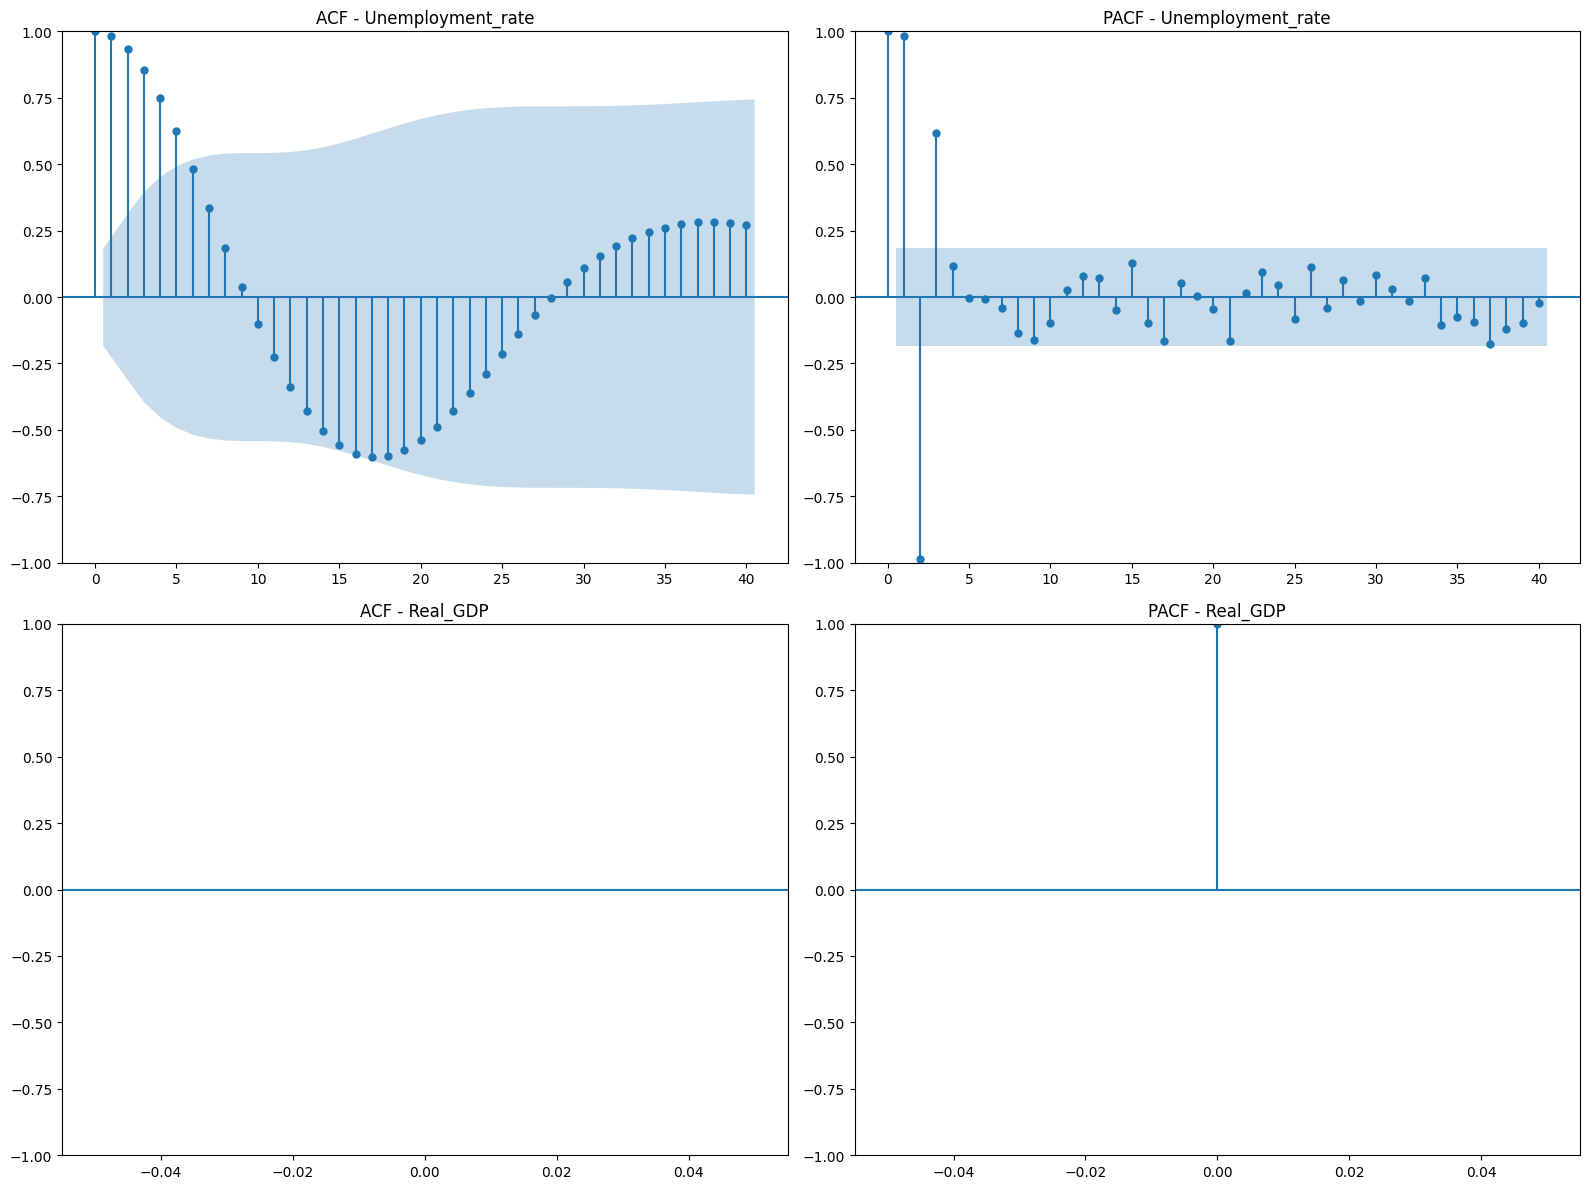

In [167]:
belgium = PreProcessing('BEL', df_unemployment, df_gdp)
belgium.ACF_PACF_plot()

In [152]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur = 6  # Lags pour Diff_Unemployment_rate
lags_gdp = 0  # Lags pour Diff_Real_GDP

In [185]:
belgium_model = ARDLAnalysis('BEL', df_unemployment, df_gdp, lags_ur, lags_gdp)
belgium_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     11.63
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           4.89e-16
Time:                        00:10:53   Log-Likelihood:                 1217.7
No. Observations:                 104   AIC:                            -2397.
Df Residuals:                      85   BIC:                            -2347.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.543e-08   2.25e-07     -0.113      0.910   -4.73e-07    4.22e-07
Unemployment_rate      -0.0010      0.001     -0.843      0.402      -0.004       0.001
Real_GDP                0.8735      0.109      8.024      0.000       0.657       1.090
Unemployment_rate_1     0.0026      0.003      0.761      0.449      -0.004       0.009
Real_GDP_1             -0.1154      0.143     -0.805      0.423      -0.400       0.170
Unemployment_rate_2    -0.0021      0.004     -0.513      0.609      -0.010       0.006
Real_GDP_2              0.1763      0.147      1.196      0.235      -0.117       0.470
Unemployment_rate_3     0.0023      0.004      0.534      0.594      -0.006       0.011
Real_GDP_3             -0.1031      0.148     -0.698      0.487      -0.397       0.191
Unemployment_rate_4    -0.0027      0.004     -0.633      0.528      -0.011       0.006
Real_GDP_4              0.0176      0.147      0.120      0.904      -0.274       0.309
Unemployment_rate_5     0.0016      0.004      0.368      0.714      -0.007       0.010
Real_GDP_5             -0.2371      0.145     -1.636      0.105      -0.525       0.051
Unemployment_rate_6    -0.0024      0.004     -0.576      0.566      -0.011       0.006
Real_GDP_6              0.1370      0.117      1.175      0.243      -0.095       0.369
Unemployment_rate_7     0.0030      0.003      0.874      0.385      -0.004       0.010
Real_GDP_7             -0.0541      0.070     -0.777      0.439      -0.192       0.084
Unemployment_rate_8    -0.0010      0.001     -0.806      0.422      -0.004       0.002
Real_GDP_8             -0.0377      0.057     -0.664      0.509      -0.151       0.075
==============================================================================
Omnibus:                        9.514   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               21.603
Skew:                           0.126   Prob(JB):                     2.04e-05
Kurtosis:                       5.218   Cond. No.                     1.06e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.31e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

la stationnarité est une condition importante pour l'application de modèles ARDL, donc différencier jusqu'à obtenir séries stationnaires.

Par ailleurs, il faut également prendre en compte le nombre approprié de retards (lags) pour chaque variable afin de spécifier correctement notre modèle.

#### Détermination du nombre de retards (lags) à considérer pour chacune des séries après différenciation.

Pour déterminer le nombre optimal de retards (lags) dans un modèle ARDL, nous pouvons utiliser des graphiques de la fonction d'autocorrélation (ACF) et de la fonction d'autocorrélation partielle (PACF). Ces graphiques peuvent nous aider à identifier les retards significatifs qui affectent la série temporelle.
Ces graphiques aident à visualiser les corrélations entre les observations à différents retards. Nous devons rechercher des retards significatifs où les corrélations sont en dehors de l'intervalle de confiance.

Si le premier pic dans la fonction d'autocorrélation (ACF) est très élevé et significatif, et qu'il est en dehors de l'intervalle de confiance, cela suggère qu'un seul retard (lag = 1) pourrait être suffisant pour capturer l'autocorrélation significative dans nos données.

Choisir un seul retard peut également simplifier notre modèle ARDL et le rendre plus interprétable. 

#### Modèle ARDL

Le modèle présenté ci-dessous est une spécification simple d'un modèle ARDL (AutoRegressive Distributed Lag). Cependant, la dynamique temporelle est partiellement prise en compte dans la mesure où le modèle inclut un lag du taux de chômage (Diff_Unemployment_rate) pour capturer l'effet retardé sur la variable dépendante (Diff2_Real_GDP).


## Application du modèle au pays sélectionné pour chaque cluster

### Pays du cluster 1

In [188]:
country_code1 = list_random_countries[0]

### Pays du cluster 2

In [189]:
country_code2 = list_random_countries[1]

### Pays du cluster 3

In [190]:
country_code3 = list_random_countries[2]

### Pays du cluster 4

In [191]:
country_code4 = list_random_countries[3]